# Курс Data Science
## 14.5 Многоклассовая классификация



В случае с бинарным классификатором все достаточно просто: если это пороговый классификатор, то на выходе он дает один из двух классов, поскольку любое значение либо меньше или равно порогу, либо больше порога. С классификатором, который дает бинарные ответы (например, "это спам" или "это не спам"), тоже все понятно: последовательно отвечая на вопросы по каким-либо признакам "да" или "нет" явно можно прийти к какому-то решению - модели надо всего лишь научиться задавать правильные вопросы.

Но что делать в случае многоклассовой классификации? Здесь возникают два вопроса: во-первых, как построить такой алгоритм, а во-вторых, как измерить его качество. Некоторые алгоритмы (такие как *случайный лес* или *наивный Байес*) способны напрямую определять несколько классов, другие (например, *линейные классификаторы* или *метод опорных векторов*) применимы только к задачам бинарной классификации. Конечно, можно построить модель, применимую к многоклассовым задачам, но зачастую бывает легче определить простой бинарный метод, потому как любую многоклассовую задачу можно свести к последовательности бинарных решений. 

Вспомним набор данных Iris. 

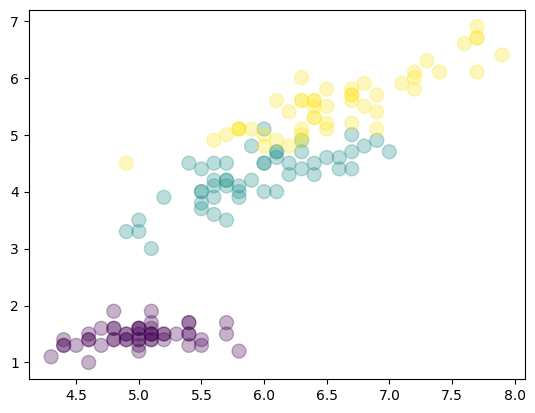

In [42]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

iris_dataset = load_iris()
x = iris_dataset.data.T[0]
y = iris_dataset.data.T[2]
plt.scatter(x, y, alpha=0.3, s=100, c=iris_dataset.target)

На этом графике прекрасно видно, как легко можно отделить один класс от двух других, а затем уже сосредоточиться на разделении оставшихся классов, сведя задачу к двум бинарным решениям:
1. Это Iris Setosa? (да или нет)
2. Если нет, проверить, это Iris Virginica? (да или нет)

Разумеется, такого рода решения мы бы хотели поручить модели машинного обучения. Существуют несколько подходов к решению задачи многоклассовой классификации. 

Первый подход называется "один против всех" - OvA или OvR (*one-versus-all strategy* или *one-vs-the-rest strategy*). Допустим, нам дана некоторая выборка данных, каждый объект которой можно отнести к одному из K классов. Идея состоит в том, чтобы построить K классификаторов, каждый из которых будет отделять один класс от всех остальных. Здесь удобнее использовать не просто ответ классификатора "да" или "нет", а вычислять оценки принадлежности, т.е. вероятность принадлежности объекта к данному классу. После того, как K таких классификаторов были построены, находим максимальную из оценок и соответствующий ей класс и возвращаем этот класс в качестве ответа.

<img src="https://248006.selcdn.ru/public/DS_Block2_M6_final/OvA.png" width="500">

Другой подход называется "каждый против каждого" - OvO (*one-vs-one*). Здесь строятся классификаторы для каждой пары классов, т.е. 0-й с 1-м, 0-й со 2-м, 1-й со 2-м и т.д. То есть в итоге, если у нас K классов, нам потребуется построить $\frac{K \cdot (K - 1)}{2}$ классификаторов. Основное преимущество данного метода заключается в том, что каждый классификатор должен быть обучен только на части тренировочного сета, состоящего из объектов двух классов, которые он должен различать.

<img src="https://248006.selcdn.ru/public/DS_Block2_M6_final/OvO.png" width="500">

Некоторые алгоритмы (например, метод опорных веторов) плохо масштабируются на размер обучающего набора данных, поэтому для подобных алгоритмов метод "один против каждого" предпочтительнее. Однако для большинства алгоритмов бинарной классификации "один против всех" подходит все-таки лучше.

Выбор метода зависит от модели. Подход "один против всех" строит линейное число классификаторов, но при этом каждый из них обучается на полной выборке. Из-за этого могут возникнуть проблемы с несбалансированными выборками - стоит помнить, что некоторые алгоритмы плохо работают в таких случаях. "Один против каждого" строит квадратичное число классификаторов, однако каждый из них обучается на небольшой подвыборке. Поэтому, если сложность алгоритма сильно зависит от размера выборки, то этот метод будет удобнее.

Scikit-Learn определяет, когда вы используете бинарный классификатор для задачи многоклассовой классификации, и автоматически запускает OvA (за исключением SVM, где используется OvO).

Посмотрим на примере логистической регрессии, реализованной в библиотеке *sklearn*, как работать с многоклассовыми выборками.

Несмотря на наличие "регрессии" в названии, логистическая регрессия фактически является широко используемым бинарным классификатором (т. е. целевой вектор может принимать только два значения). Метод логистической регрессии заключается в ограничении значения выходного сигнала функции от 0 до 1, чтобы его можно было интерпретировать как вероятность. Если $P(y_i=1|X)$ больше 0,5, прогнозируется класс 1; в противном случае прогнозируется класс 0.


Будем использовать уже знакомый нам датасет Iris. Для начала посмотрим, как логистическая регрессия работает с двумя классами.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# рассмотрим бинарный классификатор - возьмем только первые два класса
features_binary = iris_dataset.data[:100]
target_binary = iris_dataset.target[:100]

# разобьем датасет на тренировочные и тестовые данные
x_train, x_test, y_train, y_test = train_test_split(features_binary, 
                                                    target_binary,
                                                    random_state=0)

lr_bin = LogisticRegression(solver="lbfgs", random_state=0)
lr_bin_model = lr_bin.fit(x_train, y_train)
lr_bin_prediction = lr_bin_model.predict(x_test)

accuracy = accuracy_score(y_test, lr_bin_prediction)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


Обратите внимание, что в этом случае релевантно использовать метрику "доля правильных ответов", так как классы идеально сбалансированы (в выборке по 50 объектов одного и второго).

Допустим, мы хотим спрогнозировать класс нового наблюдения [.5, .5, .5, .5]. Посмотрим, как наша обученная модель справится с этим.

In [44]:
new_data = [[.5, .5, .5, .5]]
lr_bin_model.predict(new_data)

array([0])

Здесь наше новое наблюдение было предсказано как объект класса *1*. Теперь посмотрим, с какой вероятностью объект был отнесен к каждому из двух классов.

In [45]:
lr_bin_model.predict_proba(new_data)

array([[0.99139311, 0.00860689]])

Как мы видим, 39.3% того, что объект относится к классу *0*, и 60.7% того, что он относится к классу *1*.

Теперь обобщим логистическую регрессию на мультиклассовый датасет. Будем использовать все 3 класса набора данных Iris.

In [46]:
# рассмотрим мультиклассовый классификатор
features_all = iris_dataset.data
target_all = iris_dataset.target


# разобьем датасет на тренировочные и тестовые данные
x_train, x_test, y_train, y_test = train_test_split(features_all, 
                                                    target_all,
                                                    random_state=0)

lr_mult = LogisticRegression(random_state=0)
lr_mult_model = lr_bin.fit(x_train, y_train)
lr_mult_prediction = lr_bin_model.predict(x_test)

accuracy = accuracy_score(y_test, lr_mult_prediction)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Теперь посмотрим, как себя поведет классификатор с объектом [.5, .5, .5, .5] в случае с тремя классами.

In [47]:
lr_mult_model.predict(new_data)

array([0])

In [48]:
lr_bin_model.predict_proba(new_data)

array([[9.98348901e-01, 1.65105920e-03, 4.02729377e-08]])

Здесь также превалирует класс 1, но, судя по вероятностям отнесения к другим классам, можно сделать вывод, что объекты класса 1 больше похожи на объекты класса 2, чем на объекты класса 0.

Также здесь, как мы видим, доля правильных ответов значительно ниже. Однако иногда хочется посмотреть более сложные метрики. Например, в случае многоклассовой классификации бывает удобно посмотреть, как классификатор ведет себя на разных классах: какие классы чаще путает между собой и пытается ли каким-то образом усилить классификацию именно в этой части. Для этой цели подойдет уже знакомая нам *матрица ошибок*.

In [50]:
from sklearn.metrics import confusion_matrix

conf_mtrx = confusion_matrix(y_test, lr_mult_prediction)
conf_mtrx

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]], dtype=int64)

По диагонали расположены верно классифицированные объекты, измерения представляют собой совокупность классов (т.е. по оси x расположены предсказанные классы [0, 1, 2] и по оси y те же самые фактические классы). Из этой матрицы мы можем видеть, что чаще всего классификатор путает объекты из 2-го класса с объектами из 1-го. Из этого следует, что, возможно, стоит пересмотреть выбранные признаки для классификации и попробовать выбрать те, по которым совпадений по классам будет меньше. Обратите внимание, что ошибки не симметричны: если классификатор путает 2-й класс с 1-м, это не значит, что он будет путать и 1-й со 2-м (не забывайте, что в большинстве языков программирования отсчет начинается с 0, поэтому многие прикладные данные - например, номера классов объектов - также индексируются с 0).

Теперь вернемся к нашему многоклассовому классификатору. Если мы сейчас взглянем, что из себя представляет объект алгоритма, то увидим, что гиперпараметр *multi_class* по дефолту определен как "ovr", что, как мы помним, означает "one-vs-rest", то есть "один против всех".

In [55]:
lr_mult.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Сами по себе логистические регрессии являются только двоичными классификаторами, то есть они не могут обрабатывать целевые векторы с более чем двумя классами. Однако два умных расширения логистической регрессии делают именно это. В one-vs-rest (OvR) для каждого класса обучается отдельная модель, предсказывающая, является ли наблюдение этим классом или нет (что делает его проблемой двоичной классификации).
В полиномиальной же логистической регрессии (MNL) логистическая функция модели заменяется на альтернативную ей функцию, которая предсказывает вероятность принадлежности объекта к каждому из классов (примерно как в уже знакомой нам функции *predict_proba*). Одним из практических преимуществ MNL является то, что его предсказанные вероятности с использованием метода predict_proba являются более надежными (т.е. лучше откалиброваны).

Если мы хотим изменить метод OvR, стоящий по умолчанию, на *multinomial*, то надо просто переключиться при определении алгоритма на *multi_class='mnl'*